### 19-9 T5 (Text-to-Text Transfer Transformer)

2020년 2월 발표된 T5는 Text-to-Text Transfer Transformer의 약자이다. T가 5개라서 T5라고 불린다고 한다 

In [ ]:
class TFT5LayerNorm(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        """
        Construct a layernorm module in the T5 style No bias and no subtraction of mean.
        """
        super().__init__(**kwargs)
        self.variance_epsilon = epsilon

    def build(self, input_shape):
        """Build shared word embedding layer"""
        self.weight = self.add_weight("weight", shape=(input_shape[-1],), initializer="ones")
        super().build(input_shape)

    def call(self, hidden_states):
        variance = tf.math.reduce_mean(tf.math.square(hidden_states), axis=-1, keepdims=True)
        hidden_states = hidden_states * tf.math.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states


class TFT5DenseReluDense(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.wi = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi")
        self.wo = tf.keras.layers.Dense(config.d_model, use_bias=False, name="wo")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)
        self.act = tf.keras.activations.relu

    def call(self, hidden_states, training=False):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states, training=training)
        hidden_states = self.wo(hidden_states)
        return hidden_states


class TFT5GatedGeluDense(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.wi_0 = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi_0")
        self.wi_1 = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi_1")
        self.wo = tf.keras.layers.Dense(config.d_model, use_bias=False, name="wo")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)
        self.act = get_tf_activation("gelu_new")

    def call(self, hidden_states, training=False):
        hidden_gelu = self.act(self.wi_0(hidden_states))
        hidden_linear = self.wi_1(hidden_states)
        hidden_states = hidden_gelu * hidden_linear
        hidden_states = self.dropout(hidden_states, training=training)
        hidden_states = self.wo(hidden_states)
        return hidden_states


class TFT5LayerFF(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        if config.feed_forward_proj == "relu":
            self.DenseReluDense = TFT5DenseReluDense(config, name="DenseReluDense")
        elif config.feed_forward_proj == "gated-gelu":
            self.DenseReluDense = TFT5GatedGeluDense(config, name="DenseReluDense")
        else:
            raise ValueError(
                f"{self.config.feed_forward_proj} is not supported. Choose between `relu` and `gated-gelu`"
            )
        self.layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def call(self, hidden_states, training=False):
        normed_hidden_states = self.layer_norm(hidden_states)
        dense_output = self.DenseReluDense(normed_hidden_states, training=training)
        hidden_states = hidden_states + self.dropout(dense_output, training=training)
        return hidden_states


class TFT5Attention(tf.keras.layers.Layer):
    NEW_ID = itertools.count()

    def __init__(self, config, has_relative_attention_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.layer_id = next(TFT5Attention.NEW_ID)
        self.is_decoder = config.is_decoder
        self.use_cache = config.use_cache
        self.has_relative_attention_bias = has_relative_attention_bias
        self.output_attentions = config.output_attentions

        self.relative_attention_num_buckets = config.relative_attention_num_buckets
        self.d_model = config.d_model
        self.key_value_proj_dim = config.d_kv
        self.n_heads = config.num_heads
        self.inner_dim = self.n_heads * self.key_value_proj_dim

        # Mesh TensorFlow initialization to avoid scaling before softmax
        self.q = tf.keras.layers.Dense(self.inner_dim, use_bias=False, name="q")
        self.k = tf.keras.layers.Dense(self.inner_dim, use_bias=False, name="k")
        self.v = tf.keras.layers.Dense(self.inner_dim, use_bias=False, name="v")
        self.o = tf.keras.layers.Dense(self.d_model, use_bias=False, name="o")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

        self.pruned_heads = set()

    def build(self, input_shape):
        if self.has_relative_attention_bias:
            with tf.name_scope("relative_attention_bias"):
                self.relative_attention_bias = self.add_weight(
                    name="embeddings",
                    shape=[self.relative_attention_num_buckets, self.n_heads],
                )

        return super().build(input_shape)

    def prune_heads(self, heads):
        raise NotImplementedError

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593

        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on

        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer

        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        #        n = -relative_position
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (
                tf.cast(tf.math.greater(relative_position, 0), dtype=relative_position.dtype) * num_buckets
            )
            relative_position = tf.math.abs(relative_position)
        else:
            relative_position = -tf.math.minimum(relative_position, 0)
        # now n is in the range [0, inf)
        max_exact = num_buckets // 2
        is_small = tf.math.less(relative_position, max_exact)
        relative_position_if_large = max_exact + tf.cast(
            tf.math.log(relative_position / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact),
            dtype=relative_position.dtype,
        )
        relative_position_if_large = tf.math.minimum(relative_position_if_large, num_buckets - 1)
        relative_buckets += tf.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length):
        """Compute binned relative position bias"""
        context_position = tf.range(query_length)[:, None]
        memory_position = tf.range(key_length)[None, :]
        relative_position = memory_position - context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
        )
        values = tf.gather(
            self.relative_attention_bias, relative_position_bucket
        )  # shape (query_length, key_length, num_heads)
        values = tf.expand_dims(
            tf.transpose(values, [2, 0, 1]), axis=0
        )  # shape (1, num_heads, query_length, key_length)
        return values

    def call(
        self,
        hidden_states,
        mask=None,
        key_value_states=None,
        position_bias=None,
        past_key_value=None,
        layer_head_mask=None,
        query_length=None,
        use_cache=False,
        training=False,
        output_attentions=False,
    ):
        """
        Self-attention (if key_value_states is None) or attention over source sentence (provided by key_value_states).
        """
        # Input is (batch_size, query_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = shape_list(hidden_states)[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            assert (
                len(past_key_value) == 2
            ), f"past_key_value should have 2 past states: keys and values. Got {len(past_key_value)} past states"
            real_seq_length += shape_list(past_key_value[0])[2] if query_length is None else query_length

        key_length = real_seq_length if key_value_states is None else shape_list(key_value_states)[1]

        def shape(hidden_states):
            """projection"""
            return tf.transpose(
                tf.reshape(hidden_states, (batch_size, -1, self.n_heads, self.key_value_proj_dim)), perm=(0, 2, 1, 3)
            )

        def unshape(hidden_states):
            """compute context"""
            return tf.reshape(tf.transpose(hidden_states, perm=(0, 2, 1, 3)), (batch_size, -1, self.inner_dim))

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """projects hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))

            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = tf.concat([past_key_value, hidden_states], axis=2)
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query
        query_states = shape(self.q(hidden_states))  # (batch_size, n_heads, query_length, dim_per_head)

        # get key/value
        key_states = project(
            hidden_states, self.k, key_value_states, past_key_value[0] if past_key_value is not None else None
        )
        value_states = project(
            hidden_states, self.v, key_value_states, past_key_value[1] if past_key_value is not None else None
        )

        # to cope with keras serialization
        if self.is_decoder and use_cache:
            present_key_value_state = (key_states, value_states)
        else:
            present_key_value_state = None

        scores = tf.einsum(
            "bnqd,bnkd->bnqk", query_states, key_states
        )  # (batch_size, n_heads, query_length, key_length)

        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = tf.zeros((1, self.n_heads, real_seq_length, key_length))
            else:
                position_bias = self.compute_bias(real_seq_length, key_length)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -seq_length:, :]

            if mask is not None:
                position_bias = tf.cast(position_bias, dtype=mask.dtype)
                position_bias = position_bias + mask  # (batch_size, n_heads, query_length, key_length)

        scores += position_bias
        weights = tf.nn.softmax(scores, axis=-1)  # (batch_size, n_heads, query_length, key_length)
        weights = self.dropout(weights, training=training)  # (batch_size, n_heads, query_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            tf.debugging.assert_equal(
                shape_list(layer_head_mask),
                [self.n_heads],
                message=f"Head mask for a single layer should be of size {(self.n_heads)}, but is {shape_list(layer_head_mask)}",
            )
            weights = tf.reshape(layer_head_mask, (1, -1, 1, 1)) * weights

        attn_output = tf.matmul(weights, value_states)  # (batch_size, n_heads, query_length, dim_per_head)

        attn_output = self.o(unshape(attn_output))

        outputs = (attn_output,) + (present_key_value_state,) + (position_bias,)

        if output_attentions:
            outputs = outputs + (weights,)

        return outputs


class TFT5LayerSelfAttention(tf.keras.layers.Layer):
    def __init__(self, config, has_relative_attention_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.SelfAttention = TFT5Attention(
            config,
            has_relative_attention_bias=has_relative_attention_bias,
            name="SelfAttention",
        )
        self.layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def call(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        training=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.SelfAttention(
            normed_hidden_states,
            mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
            training=training,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0], training=training)
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs


class TFT5LayerCrossAttention(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.EncDecAttention = TFT5Attention(
            config,
            has_relative_attention_bias=False,
            name="EncDecAttention",
        )
        self.layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def call(
        self,
        hidden_states,
        key_value_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        query_length=None,
        use_cache=False,
        output_attentions=False,
        training=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.EncDecAttention(
            normed_hidden_states,
            mask=attention_mask,
            key_value_states=key_value_states,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            query_length=query_length,
            use_cache=use_cache,
            output_attentions=output_attentions,
            training=training,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0], training=training)
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs


class TFT5Block(tf.keras.layers.Layer):
    def __init__(self, config, has_relative_attention_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.is_decoder = config.is_decoder
        self.layer = []
        self.layer.append(
            TFT5LayerSelfAttention(
                config,
                has_relative_attention_bias=has_relative_attention_bias,
                name="layer_._0",
            )
        )
        if self.is_decoder:
            self.layer.append(
                TFT5LayerCrossAttention(
                    config,
                    name="layer_._1",
                )
            )

        self.layer.append(TFT5LayerFF(config, name=f"layer_._{len(self.layer)}"))

    def call(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        encoder_decoder_position_bias=None,
        layer_head_mask=None,
        encoder_layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        training=False,
    ):

        if past_key_value is not None:
            assert self.is_decoder, "Only decoder can use `past_key_values`"
            expected_num_past_key_values = 2 if encoder_hidden_states is None else 4

            if len(past_key_value) != expected_num_past_key_values:
                raise ValueError(
                    f"There should be {expected_num_past_key_values} past states. "
                    f"{'2 (past / key) for cross attention' if expected_num_past_key_values == 4 else ''}."
                    f"Got {len(past_key_value)} past key / value states"
                )

            self_attn_past_key_value = past_key_value[:2]
            cross_attn_past_key_value = past_key_value[2:]
        else:
            self_attn_past_key_value, cross_attn_past_key_value = None, None

        self_attention_outputs = self.layer[0](
            hidden_states,
            attention_mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=self_attn_past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
            training=training,
        )
        hidden_states, present_key_value_state = self_attention_outputs[:2]
        attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights

        if self.is_decoder and encoder_hidden_states is not None:
            # the actual query length is unknown for cross attention
            # if using past key value states. Need to inject it here
            if present_key_value_state is not None:
                query_length = shape_list(present_key_value_state[0])[2]
            else:
                query_length = None

            cross_attention_outputs = self.layer[1](
                hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                position_bias=encoder_decoder_position_bias,
                layer_head_mask=encoder_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                query_length=query_length,
                use_cache=use_cache,
                output_attentions=output_attentions,
                training=training,
            )
            hidden_states = cross_attention_outputs[0]
            # Combine self attn and cross attn key value states
            if present_key_value_state is not None:
                present_key_value_state = present_key_value_state + cross_attention_outputs[1]

            # Keep cross-attention outputs and relative position weights
            attention_outputs = attention_outputs + cross_attention_outputs[2:]

        # Apply Feed Forward layer
        hidden_states = self.layer[-1](hidden_states, training=training)
        outputs = (hidden_states,)

        # Add attentions if we output them
        outputs = outputs + (present_key_value_state,) + attention_outputs
        return outputs  # hidden-states, present_key_value_states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)

@keras_serializable
class TFT5MainLayer(tf.keras.layers.Layer):
    config_class = T5Config

    def __init__(self, config, embed_tokens=None, **kwargs):
        super().__init__(**kwargs)

        self.config = config
        self.output_hidden_states = config.output_hidden_states
        self.output_attentions = config.output_attentions
        self.use_cache = config.use_cache

        self.embed_tokens = embed_tokens
        self.is_decoder = config.is_decoder

        self.config = config
        self.num_hidden_layers = config.num_layers

        self.block = [
            TFT5Block(config, has_relative_attention_bias=bool(i == 0), name=f"block_._{i}")
            for i in range(config.num_layers)
        ]
        self.final_layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="final_layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def _prune_heads(self, heads_to_prune):
        raise NotImplementedError  # Not implemented yet in the library fr TF 2.0 models

    def call(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        encoder_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        training=False,
        **kwargs,
    ) -> Tuple:
        inputs = input_processing(
            func=self.call,
            config=self.config,
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            encoder_head_mask=encoder_head_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training,
            kwargs_call=kwargs,
        )

        if inputs["input_ids"] is not None and inputs["inputs_embeds"] is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif inputs["input_ids"] is not None:
            input_shape = shape_list(inputs["input_ids"])
            inputs["input_ids"] = tf.reshape(inputs["input_ids"], (-1, input_shape[-1]))
        elif inputs["inputs_embeds"] is not None:
            input_shape = shape_list(inputs["inputs_embeds"])[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs["inputs_embeds"] is None:
            assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
            inputs["inputs_embeds"] = self.embed_tokens(inputs["input_ids"])

        batch_size, seq_length = input_shape

        # required mask seq length can be calculated via length of past
        mask_seq_length = (
            shape_list(inputs["past_key_values"][0][0])[2] + seq_length
            if inputs["past_key_values"] is not None
            else seq_length
        )

        if inputs["attention_mask"] is None:
            inputs["attention_mask"] = tf.fill((batch_size, mask_seq_length), 1)
        if (
            self.is_decoder
            and inputs["encoder_attention_mask"] is None
            and inputs["encoder_hidden_states"] is not None
        ):
            encoder_seq_length = shape_list(inputs["encoder_hidden_states"])[1]
            inputs["encoder_attention_mask"] = tf.fill((batch_size, encoder_seq_length), 1)

        # initialize past_key_values with `None` if past does not exist
        if inputs["past_key_values"] is None:
            inputs["past_key_values"] = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        inputs["attention_mask"] = tf.cast(inputs["attention_mask"], dtype=inputs["inputs_embeds"].dtype)
        num_dims_attention_mask = len(shape_list(inputs["attention_mask"]))
        if num_dims_attention_mask == 3:
            extended_attention_mask = inputs["attention_mask"][:, None, :, :]
        elif num_dims_attention_mask == 2:
            # Provided a padding mask of dimensions [batch_size, mask_seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, mask_seq_length, mask_seq_length]
            if self.is_decoder:
                seq_ids = tf.range(mask_seq_length)
                causal_mask = tf.less_equal(
                    tf.tile(seq_ids[None, None, :], (batch_size, mask_seq_length, 1)),
                    seq_ids[None, :, None],
                )
                causal_mask = tf.cast(causal_mask, dtype=inputs["attention_mask"].dtype)
                extended_attention_mask = causal_mask[:, None, :, :] * inputs["attention_mask"][:, None, None, :]
                if inputs["past_key_values"][0] is not None:
                    extended_attention_mask = extended_attention_mask[:, :, -seq_length:, :]
            else:
                extended_attention_mask = inputs["attention_mask"][:, None, None, :]

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and  -1e9 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.

        # T5 has a mask that can compare sequence ids, we can simulate this here with this transposition
        # Cf. https://github.com/tensorflow/mesh/blob/8d2465e9bc93129b913b5ccc6a59aa97abd96ec6/mesh_tensorflow/transformer/transformer_layers.py#L270
        # extended_attention_mask = tf.math.equal(extended_attention_mask,
        #                                         tf.transpose(extended_attention_mask, perm=(-1, -2)))

        extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

        if self.is_decoder and inputs["encoder_attention_mask"] is not None:
            # If a 2D ou 3D attention mask is provided for the cross-attention
            # we need to make broadcastable to [batch_size, num_heads, mask_seq_length, mask_seq_length]
            # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
            inputs["encoder_attention_mask"] = tf.cast(
                inputs["encoder_attention_mask"], dtype=extended_attention_mask.dtype
            )
            num_dims_encoder_attention_mask = len(shape_list(inputs["encoder_attention_mask"]))
            if num_dims_encoder_attention_mask == 3:
                encoder_extended_attention_mask = inputs["encoder_attention_mask"][:, None, :, :]
            if num_dims_encoder_attention_mask == 2:
                encoder_extended_attention_mask = inputs["encoder_attention_mask"][:, None, None, :]

            # T5 has a mask that can compare sequence ids, we can simulate this here with this transposition
            # Cf. https://github.com/tensorflow/mesh/blob/8d2465e9bc93129b913b5ccc6a59aa97abd96ec6/mesh_tensorflow/transformer/transformer_layers.py#L270
            # encoder_extended_attention_mask = tf.math.equal(encoder_extended_attention_mask,
            #                                         tf.transpose(encoder_extended_attention_mask, perm=(-1, -2)))

            encoder_extended_attention_mask = (1.0 - encoder_extended_attention_mask) * -1e9
        else:
            encoder_extended_attention_mask = None

        present_key_value_states = () if inputs["use_cache"] and self.is_decoder else None
        all_hidden_states = () if inputs["output_hidden_states"] else None
        all_attentions = () if inputs["output_attentions"] else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs["inputs_embeds"], training=inputs["training"])

        for idx, (layer_module, past_key_value) in enumerate(zip(self.block, inputs["past_key_values"])):
            if inputs["output_hidden_states"]:
                all_hidden_states = all_hidden_states + (hidden_states,)
            layer_outputs = layer_module(
                hidden_states,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=inputs["encoder_hidden_states"],
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                layer_head_mask=inputs["head_mask"][idx] if inputs["head_mask"] is not None else None,
                encoder_layer_head_mask=inputs["encoder_head_mask"][idx]
                if inputs["encoder_head_mask"] is not None
                else None,
                past_key_value=past_key_value,
                use_cache=inputs["use_cache"],
                output_attentions=inputs["output_attentions"],
                training=inputs["training"],
            )

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
            hidden_states, present_key_value_state = layer_outputs[:2]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, past_key_values, (self-attention weights),
            # (self-attention position bias), (cross-attention position bias), (cross-attention weights),
            position_bias = layer_outputs[2]

            if self.is_decoder and inputs["encoder_hidden_states"] is not None:
                encoder_decoder_position_bias = layer_outputs[4 if inputs["output_attentions"] else 3]

            # append next layer key value states
            if present_key_value_state is not None and inputs["use_cache"] and self.is_decoder:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if inputs["output_attentions"]:
                all_attentions = all_attentions + (layer_outputs[3],)

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states, training=inputs["training"])

        # Add last layer
        if inputs["output_hidden_states"]:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not inputs["return_dict"]:
            outputs = (hidden_states,)
            # need to check if is decoder here as well for special cases when using keras compile
            if inputs["use_cache"] and self.is_decoder:
                outputs = outputs + (present_key_value_states,)
            if inputs["output_hidden_states"]:
                outputs = outputs + (all_hidden_states,)
            if inputs["output_attentions"]:
                outputs = outputs + (all_attentions,)
            return outputs  # last-layer hidden state, (all hidden states), (all attentions)

        if self.is_decoder:
            return TFBaseModelOutputWithPast(
                last_hidden_state=hidden_states,
                past_key_values=present_key_value_states,
                hidden_states=all_hidden_states,
                attentions=all_attentions,
            )
        else:
            return TFBaseModelOutput(
                last_hidden_state=hidden_states,
                hidden_states=all_hidden_states,
                attentions=all_attentions,
            )

#### C4
사실 T5를 소개한 논문 'Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer'은 어떤 전이학습이 더 효과적인지 결정하기 위한 대규모의 서베이 논문이다. 서베이에서 얻은 인사이트를 통해 T5라는 모델을 만들었다. 이 논문에서는 모델만 소개한 것이 아니라 Colossal Clean Crawled Corpus(C4)라 불리는 open-source pre-training dataset을 소개하기도 했다. T5와 C4를 가지고 fine-tuning을 하면 다양한 downstream task에 적용할 수 있다고 한다.

전이학습을 할 때 사용되는 데이터셋은 굉장히 중요하다. 데이터셋에 따라 사전학습된 모델의 성능이 천차만별일 수도 있다. 그러나 기존의 데이터셋은 고품질, 다양성, 많은 양이라는 좋은 데이터셋의 조건을 만족하지 못했다. 그래서 T5를 만든 저자들은 3가지 조건을 만족하는 데이터셋인 C4를 만들었다.

C4는 Wikipedia보다 2배 많은 양이고, 중복된 데이터, 불완전한 문장, 혐오 표현이나 의미 없는 내용은 제거했다. 그래서 downstream task에서 좋은 결과를 얻을 수 있고, overfitting 없이 모델 사이즈를 증가시킬 수 있다.


#### Shared Text-to-Text Framework
T5에서는 모든 NLP task를 입력과 출력이 모두 text string인 text-to-text format으로 재구성했다. 아래의 이미지는 text-to-text framework를 나타낸 것으로, text를 입력으로 하여 모델에 넣으면 결과가 text로 나오는 것을 보여준다. 참고로 녹색은 번역, 빨간색은 CoLA 태스크(문법 적합성), 노란색은 문장 유사성, 파란색은 문서 요약이다.

이런 과정을 통해서 어떤 NLP task에서든 모델, 학습 과정, 디코딩 과정, 손실함수, 하이퍼파라미터를 동일하게 사용할 수 있다. 모두 동일한 것을 사용한다면 T5는 다른 NLP 문제를 어떻게 구분할 수 있을까? 이에 대한 해답은 입력 형식에 있다.

__예1__ <br>
영-독 번역 <br>
입력 - “translate English to German: That is good.”<br>
출력 - “Das ist gut.”<br>

__예2__ <br>
MNLI benchmark <br>
입력 - “mnli premise: I hate pigeons. hypothesis: My feelings towards pigeons are filled with animosity.” <br>
출력 - “entailment”

위의 예시에서 같이 <b>task-specific(text) prefix</b>를 입력 시퀀스 앞에 추가해 모델에 넣어주는 것이다.


#### Modified MLM
T5은 입력에 corrupted token을 넣어 더 좋은 성능을 낼 수 있도록 했다. 이를 <b>denoising objectives</b>라고 하는데, 이는 T5에서만 사용한 것이 아니라 BART등 다른 모델에서도 흔히 사용하는 방법이었다. 
T5는 타겟을 랜덤으로 샘플링하고, 입력 시퀀스의 15%의 token을 single sentinel token(<X>, <Y>)로 대체했다. 각 sentinel token은 어떤 wordpiece에도 대응되지 않는 특별한 토큰으로, 시퀀스에 유일한 토큰ID로 지정되어 voca에 추가된다. 또한 연속된 단어는 하나의 sentinel token으로 여겨진다. 타켓 토큰은 입력에서 사용된 sentinel token과 final sentinel token(<Z>)이다. 이를 시각화하면 아래와 같다. 
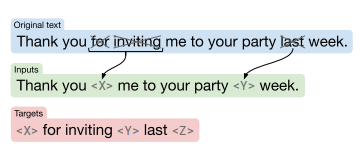 <br>
    

#### 모델 아키텍처
T5와 다른 트랜스포머 계열모델과 다른 점 중 하나는 어텐션 메커니즘에 의해 사용되는 mask가 다르다는 것이다. 아래 그림은 attention mask패턴을 나타낸 것이다. 
가장 왼쪽 그림은 모든 출력 time step에서 모든 입력을 고려하는 self-attention 메커니즘으로, encoder-decoder Transformer나 BERT에서 사용하는 마크킹 방법이고, 가운데 그림은 i번째 출력 요소가 미래의 입력에 의존하지 못하도록 하는 마스킹 방법이다. T5에서는 앞의 두 방법이 아니라  fully-visible 마스킹을 입력 시퀀스의 일부에 사용하는 causal masking with prefix라는 마스킹 방법을 사용한다.  
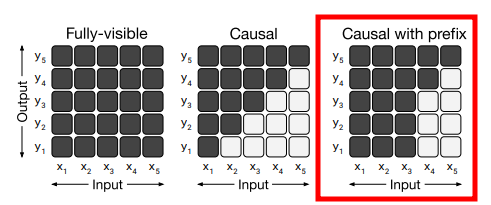 <br>
    
<b> Q. 위 그림의 "Causal with prefix"이 일반적인 causal 마스킹 방법과 다른 이유를 설명해봅시다. </b><br>
다른 모델과 T5의 또다른 차이점은 Transformer 아키텍처이다. 아래의 그림에서 block은 시퀀스이고, 선은 attention이다. 진한 선은 fully-visible masking이고, 연한 선은 causal masking을 나타낸다. T5는 오른쪽과 같이 언어모델에 prefix를 추가해 입력에 fully-visible masking할 수 있도록 했다. 즉 encoder에는 양방향 attention을, decoder(generation)에서는 단방향 attention을 사용하는 것이다.
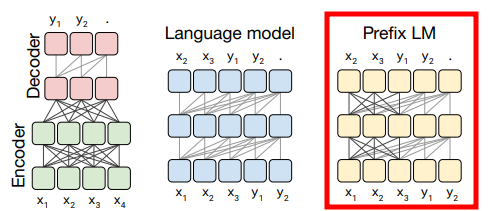 <br>
    
    
#### 새로운 task<br>
T5모델은 2가지 새로운 task를 학습했다. 그 중 하나는 <b>Closed-Book Question Answering</b>이라는 것인데, 이는 어떤 외부 지식에도 접근하지 않고 사전 학습 중 얻은 파라미터에서 저장된 정보만 사용해서 질문에 답하는 것이다. 아래서 그림에서 <M>이라는 부분을 T5가 내재된 지식에 의존해서 답을 하게 했다. 그리고 그 결과는..?
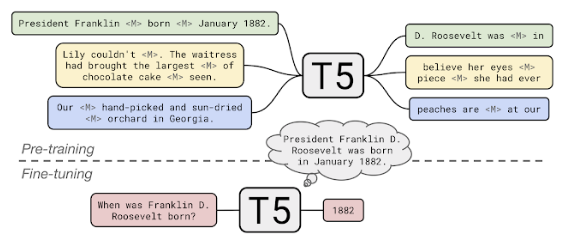 <br>
정말 놀랍게도 T5는 이 문제를 잘 해결했다. TriviaQA, WebQuestions, Natural Question에 각각 50.1%, 37.4%, 34.5% 정도의 답을 정확한 텍스트로 출력했다. <br>

T5 연구팀이 직접 이 문제를 가지고 T5와 정면도전했지만 졌다고 한다. 😂 <br>
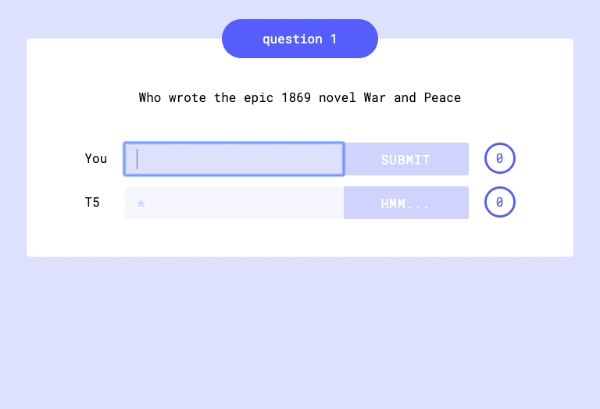 <br>
T5가 학습한 새로운 task 중 또다른 하나는 fill-in-the blank task였다. 바로 빈칸 채우기인데, 특이하게도 빈칸에 들어갈 단어의 수가 달라지면 결과도 다르게 나온다. 신기함. <br>
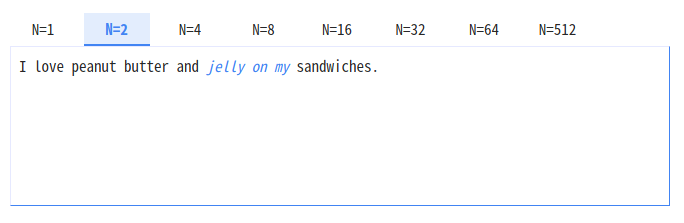 <br> 
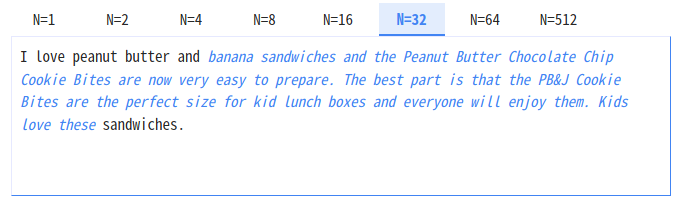
    
T5 블로그와 논문     
https://blog.research.google/2020/02/exploring-transfer-learning-with-t5.html <br>
https://arxiv.org/pdf/1910.10683v3.pdf

In [ ]:
class TFT5LayerNorm(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        """
        Construct a layernorm module in the T5 style No bias and no subtraction of mean.
        """
        super().__init__(**kwargs)
        self.variance_epsilon = epsilon

    def build(self, input_shape):
        """Build shared word embedding layer"""
        self.weight = self.add_weight("weight", shape=(input_shape[-1],), initializer="ones")
        super().build(input_shape)

    def call(self, hidden_states):
        variance = tf.math.reduce_mean(tf.math.square(hidden_states), axis=-1, keepdims=True)
        hidden_states = hidden_states * tf.math.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states


class TFT5DenseReluDense(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.wi = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi")
        self.wo = tf.keras.layers.Dense(config.d_model, use_bias=False, name="wo")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)
        self.act = tf.keras.activations.relu

    def call(self, hidden_states, training=False):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states, training=training)
        hidden_states = self.wo(hidden_states)
        return hidden_states


class TFT5GatedGeluDense(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.wi_0 = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi_0")
        self.wi_1 = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi_1")
        self.wo = tf.keras.layers.Dense(config.d_model, use_bias=False, name="wo")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)
        self.act = get_tf_activation("gelu_new")

    def call(self, hidden_states, training=False):
        hidden_gelu = self.act(self.wi_0(hidden_states))
        hidden_linear = self.wi_1(hidden_states)
        hidden_states = hidden_gelu * hidden_linear
        hidden_states = self.dropout(hidden_states, training=training)
        hidden_states = self.wo(hidden_states)
        return hidden_states


class TFT5LayerFF(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        if config.feed_forward_proj == "relu":
            self.DenseReluDense = TFT5DenseReluDense(config, name="DenseReluDense")
        elif config.feed_forward_proj == "gated-gelu":
            self.DenseReluDense = TFT5GatedGeluDense(config, name="DenseReluDense")
        else:
            raise ValueError(
                f"{self.config.feed_forward_proj} is not supported. Choose between `relu` and `gated-gelu`"
            )
        self.layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def call(self, hidden_states, training=False):
        normed_hidden_states = self.layer_norm(hidden_states)
        dense_output = self.DenseReluDense(normed_hidden_states, training=training)
        hidden_states = hidden_states + self.dropout(dense_output, training=training)
        return hidden_states


class TFT5Attention(tf.keras.layers.Layer):
    NEW_ID = itertools.count()

    def __init__(self, config, has_relative_attention_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.layer_id = next(TFT5Attention.NEW_ID)
        self.is_decoder = config.is_decoder
        self.use_cache = config.use_cache
        self.has_relative_attention_bias = has_relative_attention_bias
        self.output_attentions = config.output_attentions

        self.relative_attention_num_buckets = config.relative_attention_num_buckets
        self.d_model = config.d_model
        self.key_value_proj_dim = config.d_kv
        self.n_heads = config.num_heads
        self.inner_dim = self.n_heads * self.key_value_proj_dim

        # Mesh TensorFlow initialization to avoid scaling before softmax
        self.q = tf.keras.layers.Dense(self.inner_dim, use_bias=False, name="q")
        self.k = tf.keras.layers.Dense(self.inner_dim, use_bias=False, name="k")
        self.v = tf.keras.layers.Dense(self.inner_dim, use_bias=False, name="v")
        self.o = tf.keras.layers.Dense(self.d_model, use_bias=False, name="o")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

        self.pruned_heads = set()

    def build(self, input_shape):
        if self.has_relative_attention_bias:
            with tf.name_scope("relative_attention_bias"):
                self.relative_attention_bias = self.add_weight(
                    name="embeddings",
                    shape=[self.relative_attention_num_buckets, self.n_heads],
                )

        return super().build(input_shape)

    def prune_heads(self, heads):
        raise NotImplementedError

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593

        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on

        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer

        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        #        n = -relative_position
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (
                tf.cast(tf.math.greater(relative_position, 0), dtype=relative_position.dtype) * num_buckets
            )
            relative_position = tf.math.abs(relative_position)
        else:
            relative_position = -tf.math.minimum(relative_position, 0)
        # now n is in the range [0, inf)
        max_exact = num_buckets // 2
        is_small = tf.math.less(relative_position, max_exact)
        relative_position_if_large = max_exact + tf.cast(
            tf.math.log(relative_position / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact),
            dtype=relative_position.dtype,
        )
        relative_position_if_large = tf.math.minimum(relative_position_if_large, num_buckets - 1)
        relative_buckets += tf.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length):
        """Compute binned relative position bias"""
        context_position = tf.range(query_length)[:, None]
        memory_position = tf.range(key_length)[None, :]
        relative_position = memory_position - context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
        )
        values = tf.gather(
            self.relative_attention_bias, relative_position_bucket
        )  # shape (query_length, key_length, num_heads)
        values = tf.expand_dims(
            tf.transpose(values, [2, 0, 1]), axis=0
        )  # shape (1, num_heads, query_length, key_length)
        return values

    def call(
        self,
        hidden_states,
        mask=None,
        key_value_states=None,
        position_bias=None,
        past_key_value=None,
        layer_head_mask=None,
        query_length=None,
        use_cache=False,
        training=False,
        output_attentions=False,
    ):
        """
        Self-attention (if key_value_states is None) or attention over source sentence (provided by key_value_states).
        """
        # Input is (batch_size, query_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = shape_list(hidden_states)[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            assert (
                len(past_key_value) == 2
            ), f"past_key_value should have 2 past states: keys and values. Got {len(past_key_value)} past states"
            real_seq_length += shape_list(past_key_value[0])[2] if query_length is None else query_length

        key_length = real_seq_length if key_value_states is None else shape_list(key_value_states)[1]

        def shape(hidden_states):
            """projection"""
            return tf.transpose(
                tf.reshape(hidden_states, (batch_size, -1, self.n_heads, self.key_value_proj_dim)), perm=(0, 2, 1, 3)
            )

        def unshape(hidden_states):
            """compute context"""
            return tf.reshape(tf.transpose(hidden_states, perm=(0, 2, 1, 3)), (batch_size, -1, self.inner_dim))

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """projects hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))

            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = tf.concat([past_key_value, hidden_states], axis=2)
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query
        query_states = shape(self.q(hidden_states))  # (batch_size, n_heads, query_length, dim_per_head)

        # get key/value
        key_states = project(
            hidden_states, self.k, key_value_states, past_key_value[0] if past_key_value is not None else None
        )
        value_states = project(
            hidden_states, self.v, key_value_states, past_key_value[1] if past_key_value is not None else None
        )

        # to cope with keras serialization
        if self.is_decoder and use_cache:
            present_key_value_state = (key_states, value_states)
        else:
            present_key_value_state = None

        scores = tf.einsum(
            "bnqd,bnkd->bnqk", query_states, key_states
        )  # (batch_size, n_heads, query_length, key_length)

        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = tf.zeros((1, self.n_heads, real_seq_length, key_length))
            else:
                position_bias = self.compute_bias(real_seq_length, key_length)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -seq_length:, :]

            if mask is not None:
                position_bias = tf.cast(position_bias, dtype=mask.dtype)
                position_bias = position_bias + mask  # (batch_size, n_heads, query_length, key_length)

        scores += position_bias
        weights = tf.nn.softmax(scores, axis=-1)  # (batch_size, n_heads, query_length, key_length)
        weights = self.dropout(weights, training=training)  # (batch_size, n_heads, query_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            tf.debugging.assert_equal(
                shape_list(layer_head_mask),
                [self.n_heads],
                message=f"Head mask for a single layer should be of size {(self.n_heads)}, but is {shape_list(layer_head_mask)}",
            )
            weights = tf.reshape(layer_head_mask, (1, -1, 1, 1)) * weights

        attn_output = tf.matmul(weights, value_states)  # (batch_size, n_heads, query_length, dim_per_head)

        attn_output = self.o(unshape(attn_output))

        outputs = (attn_output,) + (present_key_value_state,) + (position_bias,)

        if output_attentions:
            outputs = outputs + (weights,)

        return outputs


class TFT5LayerSelfAttention(tf.keras.layers.Layer):
    def __init__(self, config, has_relative_attention_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.SelfAttention = TFT5Attention(
            config,
            has_relative_attention_bias=has_relative_attention_bias,
            name="SelfAttention",
        )
        self.layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def call(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        training=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.SelfAttention(
            normed_hidden_states,
            mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
            training=training,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0], training=training)
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs


class TFT5LayerCrossAttention(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.EncDecAttention = TFT5Attention(
            config,
            has_relative_attention_bias=False,
            name="EncDecAttention",
        )
        self.layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def call(
        self,
        hidden_states,
        key_value_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        query_length=None,
        use_cache=False,
        output_attentions=False,
        training=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.EncDecAttention(
            normed_hidden_states,
            mask=attention_mask,
            key_value_states=key_value_states,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            query_length=query_length,
            use_cache=use_cache,
            output_attentions=output_attentions,
            training=training,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0], training=training)
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs


class TFT5Block(tf.keras.layers.Layer):
    def __init__(self, config, has_relative_attention_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.is_decoder = config.is_decoder
        self.layer = []
        self.layer.append(
            TFT5LayerSelfAttention(
                config,
                has_relative_attention_bias=has_relative_attention_bias,
                name="layer_._0",
            )
        )
        if self.is_decoder:
            self.layer.append(
                TFT5LayerCrossAttention(
                    config,
                    name="layer_._1",
                )
            )

        self.layer.append(TFT5LayerFF(config, name=f"layer_._{len(self.layer)}"))

    def call(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        encoder_decoder_position_bias=None,
        layer_head_mask=None,
        encoder_layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        training=False,
    ):

        if past_key_value is not None:
            assert self.is_decoder, "Only decoder can use `past_key_values`"
            expected_num_past_key_values = 2 if encoder_hidden_states is None else 4

            if len(past_key_value) != expected_num_past_key_values:
                raise ValueError(
                    f"There should be {expected_num_past_key_values} past states. "
                    f"{'2 (past / key) for cross attention' if expected_num_past_key_values == 4 else ''}."
                    f"Got {len(past_key_value)} past key / value states"
                )

            self_attn_past_key_value = past_key_value[:2]
            cross_attn_past_key_value = past_key_value[2:]
        else:
            self_attn_past_key_value, cross_attn_past_key_value = None, None

        self_attention_outputs = self.layer[0](
            hidden_states,
            attention_mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=self_attn_past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
            training=training,
        )
        hidden_states, present_key_value_state = self_attention_outputs[:2]
        attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights

        if self.is_decoder and encoder_hidden_states is not None:
            # the actual query length is unknown for cross attention
            # if using past key value states. Need to inject it here
            if present_key_value_state is not None:
                query_length = shape_list(present_key_value_state[0])[2]
            else:
                query_length = None

            cross_attention_outputs = self.layer[1](
                hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                position_bias=encoder_decoder_position_bias,
                layer_head_mask=encoder_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                query_length=query_length,
                use_cache=use_cache,
                output_attentions=output_attentions,
                training=training,
            )
            hidden_states = cross_attention_outputs[0]
            # Combine self attn and cross attn key value states
            if present_key_value_state is not None:
                present_key_value_state = present_key_value_state + cross_attention_outputs[1]

            # Keep cross-attention outputs and relative position weights
            attention_outputs = attention_outputs + cross_attention_outputs[2:]

        # Apply Feed Forward layer
        hidden_states = self.layer[-1](hidden_states, training=training)
        outputs = (hidden_states,)

        # Add attentions if we output them
        outputs = outputs + (present_key_value_state,) + attention_outputs
        return outputs  # hidden-states, present_key_value_states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)

@keras_serializable
class TFT5MainLayer(tf.keras.layers.Layer):
    config_class = T5Config

    def __init__(self, config, embed_tokens=None, **kwargs):
        super().__init__(**kwargs)

        self.config = config
        self.output_hidden_states = config.output_hidden_states
        self.output_attentions = config.output_attentions
        self.use_cache = config.use_cache

        self.embed_tokens = embed_tokens
        self.is_decoder = config.is_decoder

        self.config = config
        self.num_hidden_layers = config.num_layers

        self.block = [
            TFT5Block(config, has_relative_attention_bias=bool(i == 0), name=f"block_._{i}")
            for i in range(config.num_layers)
        ]
        self.final_layer_norm = TFT5LayerNorm(epsilon=config.layer_norm_epsilon, name="final_layer_norm")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)

    def _prune_heads(self, heads_to_prune):
        raise NotImplementedError  # Not implemented yet in the library fr TF 2.0 models

    def call(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        encoder_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        training=False,
        **kwargs,
    ) -> Tuple:
        inputs = input_processing(
            func=self.call,
            config=self.config,
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            encoder_head_mask=encoder_head_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training,
            kwargs_call=kwargs,
        )

        if inputs["input_ids"] is not None and inputs["inputs_embeds"] is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif inputs["input_ids"] is not None:
            input_shape = shape_list(inputs["input_ids"])
            inputs["input_ids"] = tf.reshape(inputs["input_ids"], (-1, input_shape[-1]))
        elif inputs["inputs_embeds"] is not None:
            input_shape = shape_list(inputs["inputs_embeds"])[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs["inputs_embeds"] is None:
            assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
            inputs["inputs_embeds"] = self.embed_tokens(inputs["input_ids"])

        batch_size, seq_length = input_shape

        # required mask seq length can be calculated via length of past
        mask_seq_length = (
            shape_list(inputs["past_key_values"][0][0])[2] + seq_length
            if inputs["past_key_values"] is not None
            else seq_length
        )

        if inputs["attention_mask"] is None:
            inputs["attention_mask"] = tf.fill((batch_size, mask_seq_length), 1)
        if (
            self.is_decoder
            and inputs["encoder_attention_mask"] is None
            and inputs["encoder_hidden_states"] is not None
        ):
            encoder_seq_length = shape_list(inputs["encoder_hidden_states"])[1]
            inputs["encoder_attention_mask"] = tf.fill((batch_size, encoder_seq_length), 1)

        # initialize past_key_values with `None` if past does not exist
        if inputs["past_key_values"] is None:
            inputs["past_key_values"] = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        inputs["attention_mask"] = tf.cast(inputs["attention_mask"], dtype=inputs["inputs_embeds"].dtype)
        num_dims_attention_mask = len(shape_list(inputs["attention_mask"]))
        if num_dims_attention_mask == 3:
            extended_attention_mask = inputs["attention_mask"][:, None, :, :]
        elif num_dims_attention_mask == 2:
            # Provided a padding mask of dimensions [batch_size, mask_seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, mask_seq_length, mask_seq_length]
            if self.is_decoder:
                seq_ids = tf.range(mask_seq_length)
                causal_mask = tf.less_equal(
                    tf.tile(seq_ids[None, None, :], (batch_size, mask_seq_length, 1)),
                    seq_ids[None, :, None],
                )
                causal_mask = tf.cast(causal_mask, dtype=inputs["attention_mask"].dtype)
                extended_attention_mask = causal_mask[:, None, :, :] * inputs["attention_mask"][:, None, None, :]
                if inputs["past_key_values"][0] is not None:
                    extended_attention_mask = extended_attention_mask[:, :, -seq_length:, :]
            else:
                extended_attention_mask = inputs["attention_mask"][:, None, None, :]

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and  -1e9 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.

        # T5 has a mask that can compare sequence ids, we can simulate this here with this transposition
        # Cf. https://github.com/tensorflow/mesh/blob/8d2465e9bc93129b913b5ccc6a59aa97abd96ec6/mesh_tensorflow/transformer/transformer_layers.py#L270
        # extended_attention_mask = tf.math.equal(extended_attention_mask,
        #                                         tf.transpose(extended_attention_mask, perm=(-1, -2)))

        extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

        if self.is_decoder and inputs["encoder_attention_mask"] is not None:
            # If a 2D ou 3D attention mask is provided for the cross-attention
            # we need to make broadcastable to [batch_size, num_heads, mask_seq_length, mask_seq_length]
            # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
            inputs["encoder_attention_mask"] = tf.cast(
                inputs["encoder_attention_mask"], dtype=extended_attention_mask.dtype
            )
            num_dims_encoder_attention_mask = len(shape_list(inputs["encoder_attention_mask"]))
            if num_dims_encoder_attention_mask == 3:
                encoder_extended_attention_mask = inputs["encoder_attention_mask"][:, None, :, :]
            if num_dims_encoder_attention_mask == 2:
                encoder_extended_attention_mask = inputs["encoder_attention_mask"][:, None, None, :]

            # T5 has a mask that can compare sequence ids, we can simulate this here with this transposition
            # Cf. https://github.com/tensorflow/mesh/blob/8d2465e9bc93129b913b5ccc6a59aa97abd96ec6/mesh_tensorflow/transformer/transformer_layers.py#L270
            # encoder_extended_attention_mask = tf.math.equal(encoder_extended_attention_mask,
            #                                         tf.transpose(encoder_extended_attention_mask, perm=(-1, -2)))

            encoder_extended_attention_mask = (1.0 - encoder_extended_attention_mask) * -1e9
        else:
            encoder_extended_attention_mask = None

        present_key_value_states = () if inputs["use_cache"] and self.is_decoder else None
        all_hidden_states = () if inputs["output_hidden_states"] else None
        all_attentions = () if inputs["output_attentions"] else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs["inputs_embeds"], training=inputs["training"])

        for idx, (layer_module, past_key_value) in enumerate(zip(self.block, inputs["past_key_values"])):
            if inputs["output_hidden_states"]:
                all_hidden_states = all_hidden_states + (hidden_states,)
            layer_outputs = layer_module(
                hidden_states,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=inputs["encoder_hidden_states"],
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                layer_head_mask=inputs["head_mask"][idx] if inputs["head_mask"] is not None else None,
                encoder_layer_head_mask=inputs["encoder_head_mask"][idx]
                if inputs["encoder_head_mask"] is not None
                else None,
                past_key_value=past_key_value,
                use_cache=inputs["use_cache"],
                output_attentions=inputs["output_attentions"],
                training=inputs["training"],
            )

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
            hidden_states, present_key_value_state = layer_outputs[:2]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, past_key_values, (self-attention weights),
            # (self-attention position bias), (cross-attention position bias), (cross-attention weights),
            position_bias = layer_outputs[2]

            if self.is_decoder and inputs["encoder_hidden_states"] is not None:
                encoder_decoder_position_bias = layer_outputs[4 if inputs["output_attentions"] else 3]

            # append next layer key value states
            if present_key_value_state is not None and inputs["use_cache"] and self.is_decoder:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if inputs["output_attentions"]:
                all_attentions = all_attentions + (layer_outputs[3],)

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states, training=inputs["training"])

        # Add last layer
        if inputs["output_hidden_states"]:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not inputs["return_dict"]:
            outputs = (hidden_states,)
            # need to check if is decoder here as well for special cases when using keras compile
            if inputs["use_cache"] and self.is_decoder:
                outputs = outputs + (present_key_value_states,)
            if inputs["output_hidden_states"]:
                outputs = outputs + (all_hidden_states,)
            if inputs["output_attentions"]:
                outputs = outputs + (all_attentions,)
            return outputs  # last-layer hidden state, (all hidden states), (all attentions)

        if self.is_decoder:
            return TFBaseModelOutputWithPast(
                last_hidden_state=hidden_states,
                past_key_values=present_key_value_states,
                hidden_states=all_hidden_states,
                attentions=all_attentions,
            )
        else:
            return TFBaseModelOutput(
                last_hidden_state=hidden_states,
                hidden_states=all_hidden_states,
                attentions=all_attentions,
            )

### 19-10 Switch Transformer
2021년 1월 Google Brain AI 연구팀이 Switch Transformer라는 모델을 공개했다. Switch Transformer는 backbone 모델로 T5을 사용하여 T5와 거의 비슷한 성능을 보이지만, T5보다 4배에서 7배까지 학습 속도가 빠른 모델이었다.

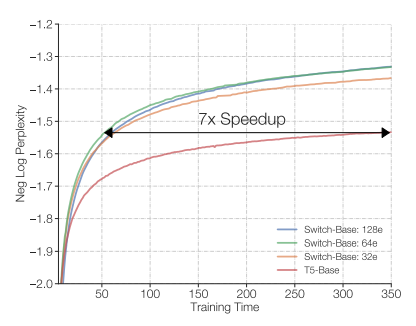 <br>
Switch Transformer의 특징 중 하나는 1조 6천억 개의 파라미터를 가졌다는 것이다. 이전까지 이렇게 많은 파라미터를 가진 모델은 없었다. 아래의 그림은 Transformer 계열 모델의 파라미터를 비교한 것인데, 파라미터가 많다고 여겨졌던 GPT3와는 비교할 수 없을 정도로 파라미터의 수가 큰 것을 알 수 있다.
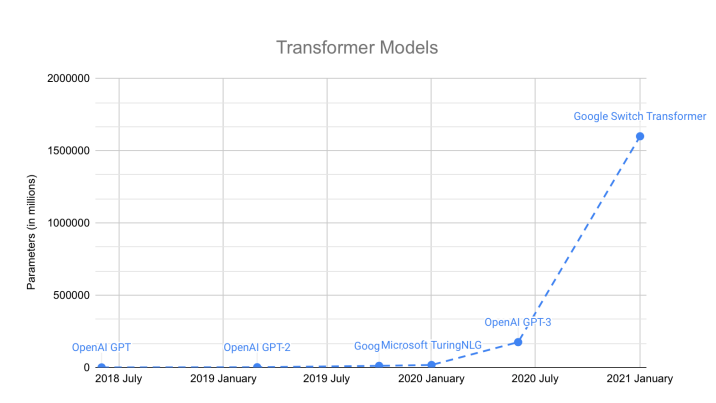 <br>
일반적으로 파라미터의 수가 증가하면 성능도 증가하지만, 계산 비용이 증가하고 학습 시간도 오래 걸리는 단점이 있다. 그러나 Switch Transformer는 이런 단점을 해결하기 위해 다양한 방법을 시도하였고, 결국 성공했다. 이제부터 Switch Transformer가 많은 수의 파라미터로 인한 단점을 보완하기 위해 사용한 여러 방법을 하나씩 알아보자.

#### MoE
Switch Transformer의 가장 큰 특징은 Transformer의 FFN(Feed Forward Network) 레이어를 MoE(Mixture of Expert)레이어로 바꾸었다는 것이다. 우선 MoE가 무엇인지 설명해야겠다. 예를 들어 '고양이'라는 클래스가 있을 때 고양이 클래스를 나타내는 이미지는 다양할 것이다. 고양이의 일부만 보일 수 있고, 다른 객체들이 고양이와 함께 있는 이미지도 있을 수 있겠다. 그런 경우 하나의 모델이 다양한 입력 이미지를 학습하기 어려울 수 있기 때문에 'expert'라는 개념을 도입했다. 고양이의 일부만 보는 expert, 객체 탐지 expert, 배경 분리 expert 등의 다양한 expert를 두고, gate 또는 router라고 불리는 곳에서 각각의 입력에 대해 적합한 expert를 할당하는 것이다.

gate에서는 하나의 입력과 가중치를 곱해 softmax를 통과시켜, 높은 확률 순으로 적당한 expert 후보를 top K개 뽑고, top K개의 expert와 입력을 연산한 결과를 가중합하여 출력하게 된다.

그런데 MoE에는 몇 가지 단점이 있었다. 구조가 복잡하고 expert간 커뮤니케이션 비용이 높으며 학습이 불안정하다는 것이다.


<b>Q. MoE를 사용하는 모델을 "Sparsely-activated model"이라 달리 부르기도 한다. 왜인지 생각해보고 맞혀볼까?</b>
앞서 설명되어 있듯이, MoE는 여러 개의 expert로 구성된다. 각 expert는 주어진 입력에 대해 독립적으로 작동하며, 다른 전문가들과 상호 작용하지 않는다. 즉 어떤 입력 데이터에 대해 일부 expert들만 활성화되고, 대부분의 나머지는 관련이 없어 작동하지 않는다. 이 점이 모든 노드가 활성화되는 FFN와 구별되기에 sparsely-activated model이라 부르기도 한다.


#### Switch Routing
Switch Transformer는 MoE의 단점을 해결하기 위해 expert를 1개만 선택하였다. 아래의 그림에서 보듯 여러 개의 토큰이 입력으로 들어오게 되면 Router라는 곳에서 각 토큰에 적합한 expert를 하나만 지정해 주는 것이다. <br>

이로 인해 성능은 기존의 MoE와 비슷하지만 router의 연산과 batch 사이즈, 그리고 routing 연산 후의 expert간 커뮤티케이션 비용이 줄어든다는 효과를 얻을 수 있었다.
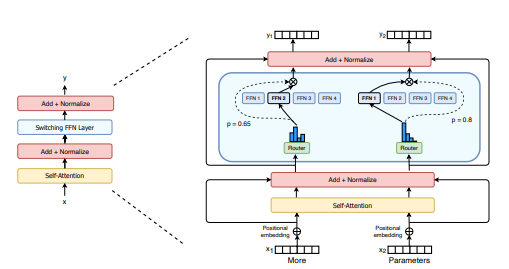 <br>


#### Distributed Switch Implementation
하나의 token에 하나의 expert를 지정한다고 해도 expert의 수가 제한되어 있기 때문에 token이 많아지면 한 expert에 여러 개의 token이 몰리게 되는 현상이 일어날 수 있다. 각 expert에 token이 고르게 배정된다면 이상적이겠지만 하나의 expert에 많은 token이 배정되고, 어떤 expert에는 token이 배정되지 않는 경우가 있을 수도 있겠다.

이런 경우를 방지하기 위해서 Switch Transformer는 Distributed Switch Implementation라는 방법을 고안해 하나의 expert에 배정될 token의 수를 제한해 뒀다. 아래의 그림에서 보듯 capacity factor라는 것을 두어 expert가 배정받을 token 수를 제한한 것이다. 예를 들어 capacity factor가 1이면 배정될 token수는 2이다. 당연하게도 capacity factor가 증가하면 계산 속도나 연산 비용은 늘어날것이다.
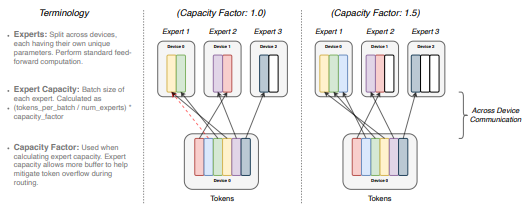 


#### Differentiable Load Balancing Loss
한 expert에 배정될 token수가 제한되었다 하더라도 일부의 expert에 token이 더 몰릴 가능성이 있다. 따라서 각각의 expert에 token이 골고루 배분되도록 Switch Transformer는 load balancing loss라는 것을 만들어 두었다. 간단히 설명하자면 router에서 각 expert에 대한 확률값의 최대값이 최소화되도록 기존의 loss에 load balancing loss라는 항을 더해 주는 것이다. 이에 대한 식은 아래와 같고, α는 0.01로 해 주었습니다. <br>
$ loss = aN∙\sum_{i=1}^Nf_i∙P_i $ <br>

#### Selective Precision
Google Brain 팀에서는 bfloat16(Brain Floating Point Format)라는 새로운 데이터타입을 만들었다. bfloat16는 floating point를 16 비트로 줄인 후, 지수부가 32만큼 넓은 range를 표현할 수 있도록 하되, precision을 희생하는 부동소수점 포맷이다. 보통 거대한 모델에서는 bfloat16을 사용하면 모델을 효율적으로 학습시킬 수 있었지만, MoE 모델에서는 bfloat16을 사용하면 발산하는 문제가 생겼다고 한다.

그래서 Switch Transformer에서는 router 레이어에서만 bfloat32를 사용하고, 그 외의 부분에서는 bfloat16을 사용해 발산하는 문제도 줄이고 효율적인 커뮤니케이션도 가능하도록 했다.

이 외에도 Switch Transformer에서 사용된 다양한 방법에는 parameter initialization를 작게 만들거나 expert dropout와 기존의 dropout을 적절히 조정해 사용하는 selective dropout을 사용하는 것 등이 있다. <br>

논문: https://arxiv.org/pdf/2101.03961.pdf <br>
코드: https://github.com/tensorflow/mesh/blob/master/mesh_tensorflow/transformer/moe.py <br>


### 19-11 ERNIE
이 모델은 PaddlePaddle이라는 중국의 오픈소스 프레임워크를 사용했다. <br>
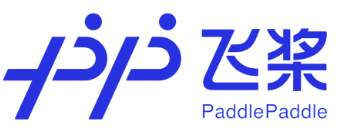 <br>

PaddlePaddle은 'PArallel Distributed Deep LEarning'의 약자로, 중국의 검색엔진 Baidu에서 만든 머신러닝 프레임워크이다. 코어 라이버러리는 C++이고, Python으로 인터페이스를 만들었다고 한다. 

그 후 PaddlePaddle을 사용한 모델이 여러 개 만들어졌고, 그 중 하나가 ERNIE이다. 사실 ERNIE는 두 가지 버전이 있다. 하나는 칭화대에서 만든 ERNIE: Enhanced Language Representation with Informative Entities이고, 다른 하나는 바이두에서 만든 ERNIE: Enhanced Representation through Knowledge Integration이다.

ERNIE라고 불리기에는 조금 억지가 아닌가 싶지만 BERT에게 친구를 만들어주긴 위한 중국인들의 노력이 가상하다😝

2가지 버전의 ERNIE 중 바이두에서 만든 ERNIE를 살펴볼 예정인데, 그 이유는 바이두의 ERNIE v3가 SuperGLUELeaderboard에서 1등을 차지하기도 했고, 바이두에서 계속해서 발전된 모델을 선보이고 있기 때문이기도 하다. 아래의 그림에서처럼 바이두의 ERNIE는 다양한 버전이 존재하고, 라이브러리도 지원되며 서버로 서비스할 수 있는 모듈까지 제공하고 있다. 
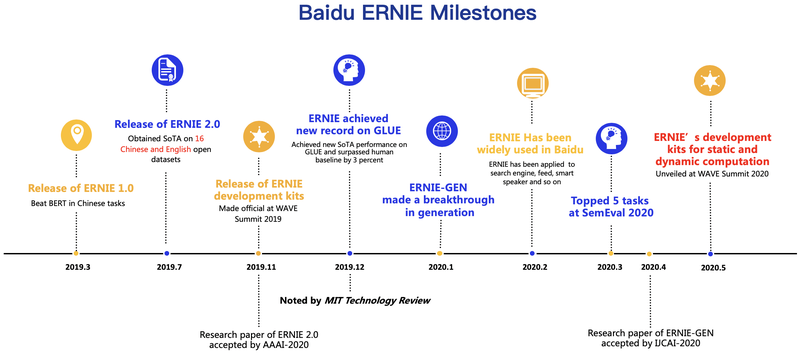 <br>
위에서도 살짝 언급했듯이 ERNIE는 버전 3까지 있는데, 이번 스텝에서는 v1만 살펴볼 예정이다. 논문 ERNIE: Enhanced Representation through Knowledge Integration에서 소개된 ERNIE v1를 살펴볼까?

#### Masking Strategies
RNIE는 아래의 한 문장으로 요약할 수 있습니다. 다양한 마스킹 전략을 통해 language representation을 향상시켰다는 거죠.

ex) ERNIE is designed to learn language representation enhanced by knowledge masking strategies, which includes entity-level masking and phrase-level masking.

ERNIE는 일반적인 마스킹 방법뿐 아니라 Phrase-Level Masking과 Entity-Level Masking을 추가로 사용했다. 일반적인 마스킹 방법은 각 글자를 단위로 하여 입력의 15%를 무작위로 마스킹했지만, ENRIE의 경우 구문 전체를 마스킹(Phrase-Level Masking)하거나 고유 명사 전체를 마스킹(Entity-Level Masking)했다. 이는 모델에 사전 지식을 주입하기 위한 것이었다.
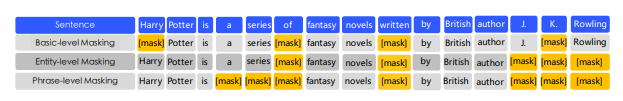 <br>


#### Transformer Encoder
ERNIE는 GPT, BERT, XLM과 같이 여러 층을 쌓은 Transformer를 Encoder로 사용했었다. 하지만 중국어 corpus를 사용하기 때문에 CJK Unicode에 있는 모든 글자에 공간을 추가해주었고, WordPiece를 사용했다고 한다.

ERNIE는 BERT와 같이 12개의 Encoder layer, 768개의 Hidden Units, 12개의 Attention Head로 구성되어 있고, 중국어 위키피디아, 바이두 백과, 바이두 뉴스, 레딧과 비슷한 포럼 공간인 바이두 티에바에서 가져온 다양한 데이터를 입력 데이터로 사용한다. 특히 바이두 티에바에서는 다이얼로그 형식의 데이터를 가지고 와 DLM task에 사용했다고 한다.

DLM(Dialogue Language Model)는 대화형 데이터를 학습하기 위해 도입된 것으로, 아래 그림에서와 같이 Dialogue embedding을 사용해 다이얼로그의 역할을 구분했다. Dialogue embedding은 BERT의 token embedding과 같은 역할을 하지만 여러 번의 턴(turn)을 가지는 대화를 표현할 수 있도록 했다. 예를 들어 QRQ, QRR, QQR과 같은 식으로. 여기서 Q는 Query, R은 Response이다. ERNIE는 Q와 R에 마스킹을 씌워 마스킹된 단어를 예측하게 하기도 하고, 가짜 대화를 만들어서 DLM이 여러 번의 턴을 가지는 대화가 진짜인지, 가짜인지 판단하도록 하기도 했다.

DLM task는 ERNIE가 대화에서 암묵적인 관계를 학습하도록 해 semantic representation을 잘 학습할 수 있도록 도와주었다. 또한 MLM과 같은 구조와 역할을 하기 때문에 BERT의 MLM 대신 DLM을 사용했다고 한다.
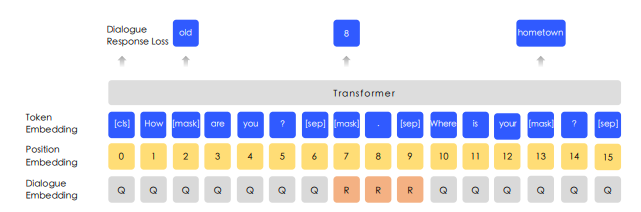 <br>

ERNIE v1이 나온지 3개월만에 v2가 나왔습니다. ERNIE v2는 pretraining할 때 여러 task를 추가해 학습하는 방식을 사용했었다. 2021년에 나온 ERNIE v3은 v1과 v2를 합친 모델이다. 자세한 내용은 아래의 논문을 참고해 보자.

- https://arxiv.org/pdf/1907.12412.pdf <br>
- https://arxiv.org/pdf/2107.02137.pdf <br>


<b> Q) ERNIE가 앞에서 설명한 모델들과 같는 차이점은 무엇이 있나요? 하나만 적어주세요. </b>
다양한 마스킹전략을 사용했다. Phrase-level masking을 통해 구문 단위를 마스킹하거나, 고유명사를 가리는 entity-level masking 활용 등이 포함된다. DLM(Dialogue Language Model)개념도 앞의 모델들과 다릅니다. 대화의 형태를 표현하기 위해 query와 response에 대한 임베딩이 단어 임베딩 과정에 포함되어 있고, 학습 단계에서도 활용된다. 이를 통해 모델이 semantic representation을 잘 학습했다고 한다.


### 19-12 마무리하며
#### 종합문제
<b> Q) 임베딩 모델은 크게 AR(AutoRegressive)모델과 AE(Auto Encoding)모델로 나뉜다. 각각에 대하여 짧게 설명해보자. </b><br>
AR(AutoRegressive) 모델: 이전 문맥을 바탕으로 다음 단어를 예측한다. 대신 문맥을 양방향으로 보기가 힘들다.
AE(AutoEncoding) 모델: 앞뒤 문맥을 모두 살펴 [MASK] 단어를 예측한다. 하지만 마스킹 처리한 토큰이 독립적으로 예측되므로 토큰 사이의 의존 관계를 학습할 수 없는데다가 fine-tuning과 evaluation 시 [MASK] 토큰이 보이지 않아 불일치가 발생할 수 있다.

<b> Q. BERT는 뛰어난 성능을 보여주며 transformer 계열 모델의 부흥을 일으켰는데요, BERT의 학습 방법 중 '두 문장의 순서가 올바른지 확인'하는 task는 무엇이었나요? </b> <br>
정답은 NSP(Next Sentence Prediction)이다! 이를 위해 BERT의 학습 데이터는 1건당 두 개의 문장으로 구성한다. 50%의 확률로 TRUE와 FALSE를 부여하도록 만든다. 이렇게 NSP를 학습하게 되면, 문장과 문장 사이의 관계를 학습할 수 있게 된다. 그러나 연산량이 적지 않은 관계로, ALBERT에서는 해당 task를 Sentence Order Prediction(SOP)로 대체한다.

In [ ]:
class TFAttention(tf.keras.layers.Layer):
    def __init__(self, nx, n_ctx, config, scale=False, **kwargs):
        super().__init__(**kwargs)

        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % config.n_head == 0
        self.n_ctx = n_ctx
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.output_attentions = config.output_attentions

        self.c_attn = TFConv1D(n_state * 3, nx, initializer_range=config.initializer_range, name="c_attn")
        self.c_proj = TFConv1D(n_state, nx, initializer_range=config.initializer_range, name="c_proj")
        self.attn_dropout = tf.keras.layers.Dropout(config.attn_pdrop)
        self.resid_dropout = tf.keras.layers.Dropout(config.resid_pdrop)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        pass

    @staticmethod
    def causal_attention_mask(nd, ns, dtype):
        """
        1-2) masked attention에서 설명한 masking 부분
        """
        i = tf.range(nd)[:, None]
        j = tf.range(ns)
        m = i >= j - ns + nd
        return tf.cast(m, dtype)

    def _attn(self, q, k, v, attention_mask, head_mask, output_attentions, training=False):
				"""
				1-2) attention 계산
        q, k, v 의 shape : [batch, heads, sequence, features]
				"""

        w = tf.matmul(q, k, transpose_b=True)
        if self.scale:
            dk = tf.cast(shape_list(k)[-1], tf.float32)  # scale attention_scores
            w = w / tf.math.sqrt(dk)

        # w shape : [batch, heads, dst_sequence, src_sequence]
        _, _, nd, ns = shape_list(w)
        b = self.causal_attention_mask(nd, ns, dtype=w.dtype)
        b = tf.reshape(b, [1, 1, nd, ns])
        w = w * b - 1e4 * (1 - b)

        if attention_mask is not None:
            # attention mask 적용
            w = w + attention_mask

        w = tf.nn.softmax(w, axis=-1)
        w = self.attn_dropout(w, training=training)

        # Mask heads if we want to
        if head_mask is not None:
            w = w * head_mask

        outputs = [tf.matmul(w, v)]
        if output_attentions:
            outputs.append(w)
        return outputs

    def merge_heads(self, x):
        x = tf.transpose(x, [0, 2, 1, 3])
        x_shape = shape_list(x)
        new_x_shape = x_shape[:-2] + [x_shape[-2] * x_shape[-1]]
        return tf.reshape(x, new_x_shape)

    def split_heads(self, x):
        x_shape = shape_list(x)
        new_x_shape = x_shape[:-1] + [self.n_head, x_shape[-1] // self.n_head]
        x = tf.reshape(x, new_x_shape)
        return tf.transpose(x, (0, 2, 1, 3))  # (batch, head, seq_length, head_features)

    def call(self, x, layer_past, attention_mask, head_mask, use_cache, output_attentions, training=False):
        x = self.c_attn(x)
        query, key, value = tf.split(x, 3, axis=2)
        query = self.split_heads(query)
        key = self.split_heads(key)
        value = self.split_heads(value)
        if layer_past is not None:
            past_key, past_value = tf.unstack(layer_past, axis=0)
            key = tf.concat([past_key, key], axis=-2)
            value = tf.concat([past_value, value], axis=-2)

        # keras serialization을 위한 코드
        if use_cache:
            present = tf.stack([key, value], axis=0)
        else:
            present = (None,)

        attn_outputs = self._attn(query, key, value, attention_mask, head_mask, output_attentions, training=training)
        a = attn_outputs[0]

        a = self.merge_heads(a)
        a = self.c_proj(a)
        a = self.resid_dropout(a, training=training)

        outputs = [a, present] + attn_outputs[1:]
        return outputs  # a, present, (attentions)


class TFMLP(tf.keras.layers.Layer):
"""
Transformer의 Decoder Block에서 Feed Foward를 구현해 둔 부분
"""
    def __init__(self, n_state, config, **kwargs):
        super().__init__(**kwargs)
        nx = config.n_embd
        self.c_fc = TFConv1D(n_state, nx, initializer_range=config.initializer_range, name="c_fc")
        self.c_proj = TFConv1D(nx, n_state, initializer_range=config.initializer_range, name="c_proj")
        self.act = get_tf_activation("gelu")
        self.dropout = tf.keras.layers.Dropout(config.resid_pdrop)

    def call(self, x, training=False):
        h = self.act(self.c_fc(x)) # conv1d로 flatten 후 activation 적용
        h2 = self.c_proj(h)
        h2 = self.dropout(h2, training=training)
        return h2


class TFBlock(tf.keras.layers.Layer):
"""
Transformer의 Decoder Block을 구현해 둔 부분
"""
    def __init__(self, n_ctx, config, scale=False, **kwargs):
        super().__init__(**kwargs)
        nx = config.n_embd
        inner_dim = config.n_inner if config.n_inner is not None else 4 * nx
        self.ln_1 = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_epsilon, name="ln_1")
        self.attn = TFAttention(nx, n_ctx, config, scale, name="attn")
        self.ln_2 = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_epsilon, name="ln_2")
        self.mlp = TFMLP(inner_dim, config, name="mlp")

    def call(self, x, layer_past, attention_mask, head_mask, use_cache, output_attentions, training=False):
        a = self.ln_1(x)
        output_attn = self.attn(
            a, layer_past, attention_mask, head_mask, use_cache, output_attentions, training=training
        )
        a = output_attn[0]  # output_attn: a, present, (attentions)
        x = x + a

        m = self.ln_2(x)
        m = self.mlp(m, training=training)
        x = x + m

        outputs = [x] + output_attn[1:]
        return outputs  # x, present, (attentions)


@keras_serializable
class TFGPT2MainLayer(tf.keras.layers.Layer):
"""
모델의 전체 구조
"""
    config_class = GPT2Config

    def __init__(self, config, *inputs, **kwargs):
        super().__init__(*inputs, **kwargs)
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.use_cache = config.use_cache
        self.return_dict = config.use_return_dict

        self.num_hidden_layers = config.n_layer
        self.vocab_size = config.vocab_size
        self.n_embd = config.n_embd

        self.wte = TFSharedEmbeddings(
            config.vocab_size, config.hidden_size, initializer_range=config.initializer_range, name="wte"
        )
        self.wpe = tf.keras.layers.Embedding(
            config.n_positions,
            config.n_embd,
            embeddings_initializer=get_initializer(config.initializer_range),
            name="wpe",
        )
        self.drop = tf.keras.layers.Dropout(config.embd_pdrop)
        self.h = [TFBlock(config.n_ctx, config, scale=True, name="h_._{}".format(i)) for i in range(config.n_layer)]
        self.ln_f = tf.keras.layers.LayerNormalization(epsilon=config.layer_norm_epsilon, name="ln_f")

    def get_input_embeddings(self):
        return self.wte

    def set_input_embeddings(self, value):
        self.wte.weight = value
        self.wte.vocab_size = self.wte.weight.shape[0]

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
        """
        raise NotImplementedError

    def call(
        self,
        inputs,
        past=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        training=False,
    ):
        if isinstance(inputs, (tuple, list)):
            input_ids = inputs[0]
            past = inputs[1] if len(inputs) > 1 else past
            attention_mask = inputs[2] if len(inputs) > 2 else attention_mask
            token_type_ids = inputs[3] if len(inputs) > 3 else token_type_ids
            position_ids = inputs[4] if len(inputs) > 4 else position_ids
            head_mask = inputs[5] if len(inputs) > 5 else head_mask
            inputs_embeds = inputs[6] if len(inputs) > 6 else inputs_embeds
            use_cache = inputs[7] if len(inputs) > 7 else use_cache
            output_attentions = inputs[8] if len(inputs) > 8 else output_attentions
            output_hidden_states = inputs[9] if len(inputs) > 9 else output_hidden_states
            return_dict = inputs[10] if len(inputs) > 10 else return_dict
            assert len(inputs) <= 11, "Too many inputs."
        elif isinstance(inputs, (dict, BatchEncoding)):
            input_ids = inputs.get("input_ids")
            past = inputs.get("past", past)
            attention_mask = inputs.get("attention_mask", attention_mask)
            token_type_ids = inputs.get("token_type_ids", token_type_ids)
            position_ids = inputs.get("position_ids", position_ids)
            head_mask = inputs.get("head_mask", head_mask)
            inputs_embeds = inputs.get("inputs_embeds", inputs_embeds)
            use_cache = inputs.get("use_cache", use_cache)
            output_attentions = inputs.get("output_attentions", output_attentions)
            output_hidden_states = inputs.get("output_hidden_states", output_hidden_states)
            return_dict = inputs.get("return_dict", return_dict)
            assert len(inputs) <= 11, "Too many inputs."
        else:
            input_ids = inputs

        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        use_cache = use_cache if use_cache is not None else self.use_cache
        return_dict = return_dict if return_dict is not None else self.return_dict

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = shape_list(input_ids)
            input_ids = tf.reshape(input_ids, [-1, input_shape[-1]])
        elif inputs_embeds is not None:
            input_shape = shape_list(inputs_embeds)[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = shape_list(past[0][0])[-2]
        if position_ids is None:
            position_ids = tf.range(past_length, input_shape[-1] + past_length, dtype=tf.int32)[tf.newaxis, :]

        if attention_mask is not None:
            # 3D attention mask 만들기
            # Sizes : [batch_size, 1, 1, to_seq_length]
            # 3D attention mask를 [batch_size, num_heads, from_seq_length, to_seq_length]로 브로드캐스팅

            attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]

            # attention_mask가 1.0이면 포함, 0.0이면 미포함 하여 attention 계산
            attention_mask = tf.cast(attention_mask, tf.float32)
            attention_mask = (1.0 - attention_mask) * -10000.0
        else:
            attention_mask = None

        # head_mask가 1.0이면, head를 유지
        # attention_probs : shape bsz x n_heads x N x N
        # input head_mask : shape [num_heads] 또는 [num_hidden_layers x num_heads]
        # head_mask : shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        if head_mask is not None:
            raise NotImplementedError
        else:
            head_mask = [None] * self.num_hidden_layers
            # head_mask = tf.constant([0] * self.num_hidden_layers)

        position_ids = tf.reshape(position_ids, [-1, shape_list(position_ids)[-1]])

        if inputs_embeds is None:
            inputs_embeds = self.wte(input_ids, mode="embedding")
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_ids = tf.reshape(token_type_ids, [-1, shape_list(token_type_ids)[-1]])
            token_type_embeds = self.wte(token_type_ids, mode="embedding")
        else:
            token_type_embeds = 0
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        hidden_states = self.drop(hidden_states, training=training)

        output_shape = input_shape + [shape_list(hidden_states)[-1]]

        presents = () if use_cache else None
        all_attentions = () if output_attentions else None
        all_hidden_states = () if output_hidden_states else None
        for i, (block, layer_past) in enumerate(zip(self.h, past)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (tf.reshape(hidden_states, output_shape),)

            outputs = block(
                hidden_states,
                layer_past,
                attention_mask,
                head_mask[i],
                use_cache,
                output_attentions,
                training=training,
            )

            hidden_states, present = outputs[:2]
            if use_cache:
                presents = presents + (present,)

            if output_attentions:
                all_attentions = all_attentions + (outputs[2],)

        hidden_states = self.ln_f(hidden_states)

        hidden_states = tf.reshape(hidden_states, output_shape)
        # Add last hidden state
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if output_attentions:
            attention_output_shape = input_shape[:-1] + [-1] + shape_list(all_attentions[0])[-2:]
            all_attentions = tuple(tf.reshape(t, attention_output_shape) for t in all_attentions)

        if not return_dict:
            return tuple(v for v in [hidden_states, presents, all_hidden_states, all_attentions] if v is not None)

        return TFBaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=presents,
            hidden_states=all_hidden_states,
            attentions=all_attentions,
        )

In [ ]:
<Input Transformation> <br>
    
![image.png](attachment:image.png) <br>